In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load the dataset
df = pd.read_csv('deforestation_dataset.csv')

# Initial inspection
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset shape: (100, 14)

First 5 rows:
     Country  Year  Forest_Loss_Area_km2  Tree_Cover_Loss_percent  \
0  Indonesia  1971                   560                 8.929641   
1     Brazil  1927                  3303                 4.638441   
2     Russia  1961                  4466                 4.679313   
3  Australia  1967                  3658                 1.535528   
4  Australia  1987                  2682                 8.035841   

   CO2_Emission_mt  Rainfall_mm  Population  GDP_Billion_USD  \
0              304  1635.715350    86759840      2551.805035   
1              341  1454.430241    83798502      2637.895996   
2              298  1744.809660    41477592      2880.724721   
3              285  1541.645853    71475964      2525.516988   
4              450  1752.997736    16256333       608.916586   

   Agriculture_Land_Percent  Deforestation_Policy_Strictness  \
0                 59.316366                                3   
1                 14.211099     

In [7]:


# Convert categorical columns to numerical
# For 'Country' we'll use label encoding
le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])

# For other categorical-like columns that are actually ordinal (like Policy_Strictness)
# We'll keep them as is since they're already numerical

# Feature scaling
scaler = StandardScaler()
numerical_cols = ['CO2_Emission_mt', 'Rainfall_mm', 'Population', 'GDP_Billion_USD', 
                 'Agriculture_Land_Percent', 'Corruption_Index', 'International_Aid_Million_USD',
                 'Illegal_Lumbering_Incidents', 'Protected_Areas_Percent']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Select target variable (let's use Forest_Loss_Area_km2)
target = 'Forest_Loss_Area_km2'
features = [col for col in df.columns if col not in [target, 'Tree_Cover_Loss_percent', 'Year']]

# Split data into features and target
X = df[features]
y = df[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (80, 11)
Test set shape: (20, 11)


In [3]:
# Initialize SVM model with linear kernel
svm_model = SVR(kernel='linear')

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nInitial Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")


Initial Model Performance:
MAE: 1010.41
MSE: 1375292.32
RMSE: 1172.73
R-squared: -0.29


In [4]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize grid search
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

print("\nBest Parameters:", best_params)

# Evaluate tuned model
y_pred_tuned = best_svm.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\nTuned Model Performance:")
print(f"MAE: {mae_tuned:.2f}")
print(f"MSE: {mse_tuned:.2f}")
print(f"RMSE: {rmse_tuned:.2f}")
print(f"R-squared: {r2_tuned:.2f}")


Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}

Tuned Model Performance:
MAE: 1047.70
MSE: 1548798.09
RMSE: 1244.51
R-squared: -0.45


Feature importance visualization is most meaningful for linear kernel.


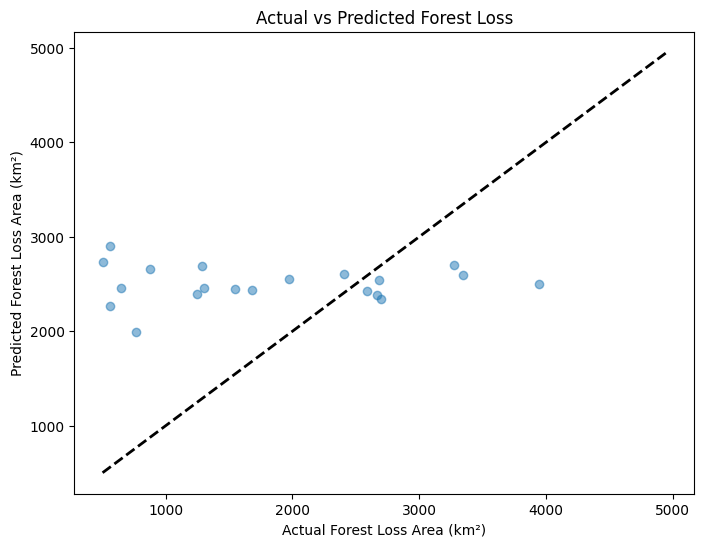

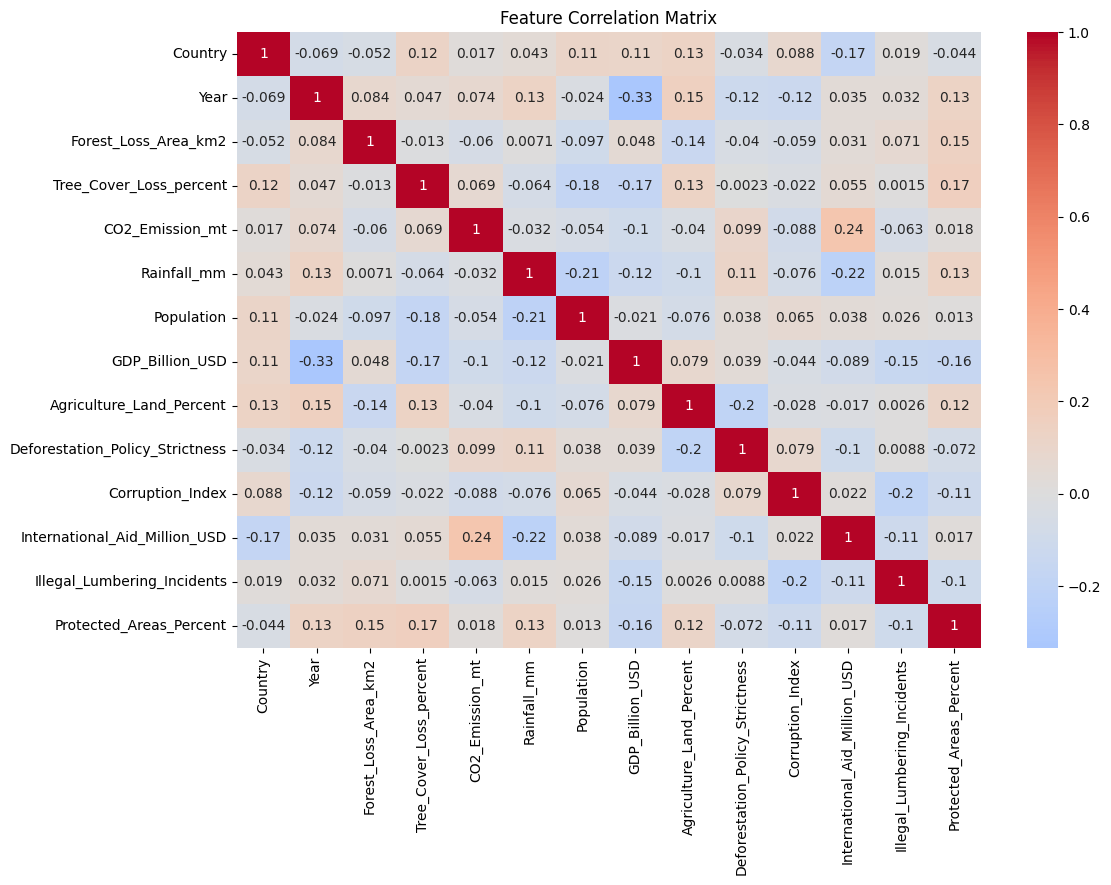

In [5]:
# Feature importance for linear kernel
if best_params['kernel'] == 'linear':
    importance = best_svm.coef_[0]
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance in SVM Model (Linear Kernel)')
    plt.show()
else:
    print("Feature importance visualization is most meaningful for linear kernel.")

# Visualize actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Forest Loss Area (km²)')
plt.ylabel('Predicted Forest Loss Area (km²)')
plt.title('Actual vs Predicted Forest Loss')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [6]:
# Generate insights based on the model
print("\nKey Insights from the SVM Model:")

if best_params['kernel'] == 'linear':
    top_features = feature_importance.head(3)['Feature'].values
    print(f"1. The most significant drivers of deforestation are: {', '.join(top_features)}")
else:
    print("1. For non-linear kernels, feature importance is more complex to interpret directly.")

# Example recommendations
print("\nRecommendations for Deforestation Mitigation:")
print("1. Strengthen deforestation policies in countries with high agricultural land use")
print("2. Increase protected areas in regions with high corruption indices")
print("3. Target international aid to countries with high illegal lumbering incidents")
print("4. Implement economic incentives for countries to reduce CO2 emissions from deforestation")

# You can add more specific recommendations based on your feature importance analysis


Key Insights from the SVM Model:
1. For non-linear kernels, feature importance is more complex to interpret directly.

Recommendations for Deforestation Mitigation:
1. Strengthen deforestation policies in countries with high agricultural land use
2. Increase protected areas in regions with high corruption indices
3. Target international aid to countries with high illegal lumbering incidents
4. Implement economic incentives for countries to reduce CO2 emissions from deforestation
